In [ ]:
# importing necessary library
import tensorflow as tf 
from tensorflow import keras
import cv2
import os 
import numpy as np 
import random 
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# **Datasets**

In [ ]:
# data directory
os.listdir('/kaggle/input/watermarked-not-watermarked-images/wm-nowm')

['.checkpoint', 'valid', 'train']

In [ ]:
# directory paths of train and test data
train_path = '/kaggle/input/watermarked-not-watermarked-images/wm-nowm/train'
valid_path = '/kaggle/input/watermarked-not-watermarked-images/wm-nowm/valid'

# **Data Pre-Processing**
 

In [ ]:
def takeFileName(filedir): 
    filename = np.array(filedir.split('/'))[-1]
    return filename

In [ ]:
def matchFileNames(wmdir, nwmdir, dname_wm, dname_nwm):
    sorted_wm_arr = np.array([])
    sorted_nwm_arr = np.array([])
    wm_arr = list(wmdir)
    nwm_arr = list(nwmdir)
    length = len(wmdir) if len(wmdir) >= len(nwmdir) else len(nwmdir)
    for pos in range(length):
        try:
            if length == len(wmdir): # more images in watermarked array
                exist_nwm = nwm_arr.index(wm_arr[pos])
                sorted_wm_arr = np.append(sorted_wm_arr, dname_wm + wmdir[pos]) # this is the iterable
                sorted_nwm_arr = np.append(sorted_nwm_arr, dname_nwm + nwmdir[exist_nwm]) # this is the match
            elif length == len(nwndir): # more images in nonwatermarked array
                exist_wm = wmarr.index(nwmarr[pos])
                sorted_wm_arr = np.append(sorted_wm_arr, dname_wm + wmdir[exist_wm]) # this is the match
                sorted_nwm_arr = np.append(sorted_nwm_arr, dname_nwm + nwndir[pos]) # this is the iterable
        except ValueError: 
            continue
    return sorted_wm_arr, sorted_nwm_arr

#  Sort - watermarked and non watermarked images 

In [ ]:
# training images
train_path_wm_images = '../input/watermarked-not-watermarked-images/wm-nowm/train/watermark/'
train_path_nwm_images = '../input/watermarked-not-watermarked-images/wm-nowm/train/no-watermark/'

tp_wm = np.array([]) # array with watermarked image names
tp_nwm = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(train_path_wm_images, topdown=True): 
    for file in files:
        tp_wm = np.append(tp_wm, takeFileName(file)) 
    
for root, dirs, files in os.walk(train_path_nwm_images, topdown=True):
    for file in files:
        tp_nwm = np.append(tp_nwm, takeFileName(file))
        
tp_wm_sorted, tp_nwm_sorted = matchFileNames(tp_wm, tp_nwm, train_path_wm_images, train_path_nwm_images)

In [ ]:
# validation images
valid_path_wm_images = '../input/watermarked-not-watermarked-images/wm-nowm/valid/watermark/'
valid_path_nwm_images = '../input/watermarked-not-watermarked-images/wm-nowm/valid/no-watermark/'

vp_wm = np.array([]) # array with watermarked image names
vp_nwm = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(valid_path_wm_images, topdown=True): 
    for file in files:
        vp_wm = np.append(vp_wm, takeFileName(file)) 
    
for root, dirs, files in os.walk(valid_path_nwm_images, topdown=True): 
    for file in files:
        vp_nwm = np.append(vp_nwm, takeFileName(file)) 
        
vp_wm_sorted, vp_nwm_sorted = matchFileNames(vp_wm, vp_nwm, valid_path_wm_images, valid_path_nwm_images)

In [ ]:
# dimension to resize to 
width = 148 
height = 148
dim = (width, height)

def createPixelArr(files):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e) # some error thrown in imread or resize
    return np.array(data)

train_wm_pVal = createPixelArr(tp_wm_sorted)
train_nwm_pVal = createPixelArr(tp_nwm_sorted)

val_wm_pVal = createPixelArr(vp_wm_sorted)
val_nwm_pVal = createPixelArr(vp_nwm_sorted) 

# **Train-Test Split: 90-10**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_wm_pVal, train_nwm_pVal, train_size=.90, random_state=1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=.90, random_state=1) 

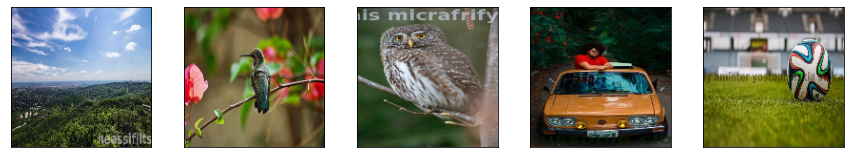

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
plt.show()

# Creating function for Data Augmentation

In [ ]:
def data_augmentation(inputImage): # run image through all augmentation methods
    return randomContrast(randomBrightness(inputImage)).numpy()
def randomFlip(pic): # flips the image up and down before left and right at random
    return tf.image.random_flip_up_down(tf.image.random_flip_left_right(pic, 1), 1)
def randomBrightness(pic): # makes the image a random brightness from 1% to 25%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.25), 1)
def randomContrast(pic): # contrasts the image from 5% to 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

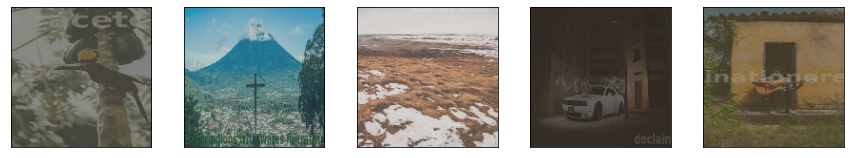

In [ ]:
# Output Tensorflow data augmented images
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    augmented_image = data_augmentation(X_train[random.randint(1, len(X_train))]) # send 25 images into data augmentation
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)) # not using cv2 as it messed up the code
plt.show()

In [ ]:
#apply data augmentation to the X_train and y_train
data_augmented_X = [] 
data_augmented_y = []
for image in X_train:
    data_augmented_X.append(data_augmentation(image))
for image in y_train:
    data_augmented_y.append(data_augmentation(image))
    
    
    
data_augmented_X_val = [] 
data_augmented_y_val = []
for image in X_val:
    data_augmented_X_val.append(data_augmentation(image))
for image in y_val:
    data_augmented_y_val.append(data_augmentation(image))

In [ ]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

X_val = np.append(X_train, data_augmented_X_val, axis=0)
y_val = np.append(y_train, data_augmented_y_val, axis=0)

In [ ]:
# normalization
X_train = X_train / 255
y_train = y_train / 255
X_test = X_test / 255
y_test = y_test / 255
X_val = X_val / 255
y_val = y_val / 255

# Convolutional Encoder 

In [ ]:
def create_model(img_x, img_y):
    
    x = Input(shape=(img_x, img_y, 3))
    e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
    batchnorm_1 = BatchNormalization()(pool1)
    
    e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
    batchnorm_2 = BatchNormalization()(pool2)
    
    e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
    h = MaxPooling2D((2, 2), padding='same')(e_conv3)
    d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    up1 = UpSampling2D((2, 2))(d_conv1)
    d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(d_conv2)
    d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2, 2))(d_conv3)
    r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    
    model = Model(x, r)
    # metric used here is accuracy , optimizer as Adam and loss function as mean squared error
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics="accuracy") 
    return model

In [ ]:
watermark_auto_encoder = create_model(width, height)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
89/89 [==============================] - 11s 85ms/step - loss: 0.0275 - accuracy: 0.5004 - val_loss: 0.0495 - val_accuracy: 0.5403
Epoch 2/30
89/89 [==============================] - 4s 44ms/step - loss: 0.0166 - accuracy: 0.6822 - val_loss: 0.0432 - val_accuracy: 0.5006
Epoch 3/30
89/89 [==============================] - 4s 44ms/step - loss: 0.0171 - accuracy: 0.6911 - val_loss: 0.0319 - val_accuracy: 0.6121
Epoch 4/30
89/89 [==============================] - 4s 47ms/step - loss: 0.0157 - accuracy: 0.7003 - val_loss: 0.0184 - val_accuracy: 0.6820
Epoch 5/30
89/89 [==============================] - 4s 44ms/step - loss: 0.0147 - accuracy: 0.7157 - val_loss: 0.0205 - val_accuracy: 0.6850
Epoch 6/30
89/89 [==============================] - 4s 44ms/step - loss: 0.0150 - accuracy: 0.6892 - val_loss: 0.0184 - val_accuracy: 0.6794
Epoch 7/30
89/89 [==============================] - 4s 44ms/step - loss: 0.0151 - accuracy: 0.6791 - val_loss: 0.0141 - val_accuracy: 0.7212
Epoch 8/30
8

In [ ]:
result = watermark_auto_encoder.predict(X_test)
watermark_auto_encoder.evaluate(y_test, result)


6/6 [==============================] - 0s 11ms/step - loss: 5.6299e-04 - accuracy: 0.9719


[0.0005629884544759989, 0.9719242453575134]

In [ ]:
watermark_auto_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 148, 148, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        128   

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


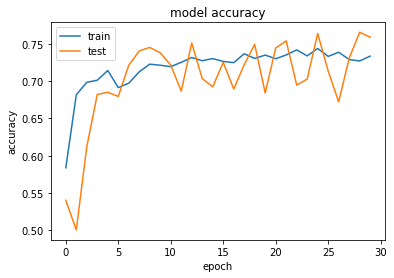

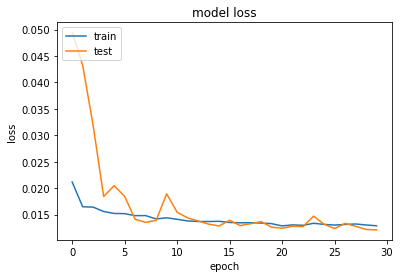

In [ ]:

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Actual vs Predictions 

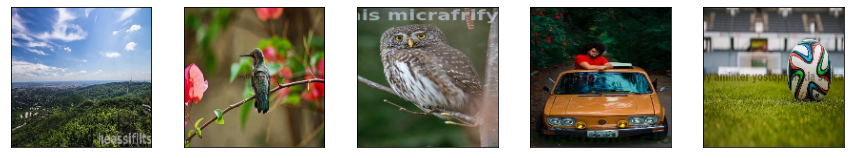

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

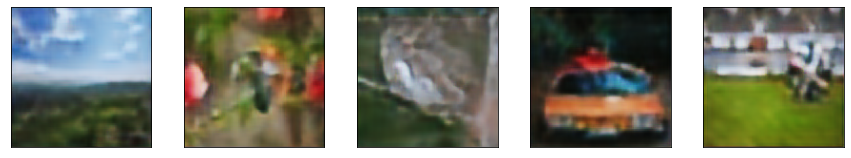

In [ ]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()